__Simple Gaussian example__:

 * use 2 gaussian to represent data
 * construct graph 
 * spectral cluster with normalized and unnormalized laplacian
 * plot new representation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pylab as pl
%matplotlib inline

__Generating dataset__:
 * <span style="color:red">two Gaussian</span>
 * <span style="color:red">two disks</span>
 * <span style="color:red">two parabola</span>

In [35]:
def generateTwoGaussian():
    mean1 = [-2, -2]
    cov1 = [[1, 0], [0, 1]]  # diagonal covariance
    mean2 = [2,2]
    cov2 = [[1, 0], [0, 1]]  # diagonal covariance

    # data
    x = np.zeros(200)
    y = np.zeros(200)
    label = np.zeros(200)
    x[:100], y[:100] = np.random.multivariate_normal(mean1, cov1, 100).T
    x[100:], y[100:] = np.random.multivariate_normal(mean2, cov2, 100).T
    label[100:] = np.ones(100)
    return x,y,label,"Gaussian"

def plotData(x,y,label,dataName):
    plt.plot(x[label==0], y[label==0], 'bo')
    plt.plot(x[label==1], y[label==1], 'ro')
    plt.axis('equal')
    plt.savefig(dataName+'.jpg')
    plt.show()

In [3]:
def generateTwoDisks():
    angle = np.arange(0, np.pi*2, 0.15)

    r1 = 50
    r2 = 20
    size = angle.shape[0]

    x1 = r1 * np.cos(angle)
    y1 = r1 * np.sin(angle)

    x2 = r2 * np.cos(angle)
    y2 = r2 * np.sin(angle)


    EACH = 10
    X = np.zeros(2*size*EACH)
    Y = np.zeros(2*size*EACH)
    label = np.zeros(2*size*EACH)
    label[size*EACH:] = np.ones(size*EACH)

    cov = [[5, 0], [0, 5]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH],Y[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH).T
        X[(i+size)*EACH:(i+size+1)*EACH],Y[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH).T
    return X,Y,label,"Disks"

In [4]:
def generateTwoParabola():
    x1 = np.linspace(-10, 10, 40)
    y1 = .22*x1**2 + .024*x1 + .04  

    x2 = np.linspace(0, 20, 40)
    y2 = -.2*(x2-10)**2 - .024*(x2-10) + 35

    size = x1.shape[0]
    EACH = 10
    X = np.zeros(2*size*EACH)
    Y = np.zeros(2*size*EACH)
    label = np.zeros(2*size*EACH)
    label[size*EACH:] = np.ones(size*EACH)

    cov = [[1, 0], [0, 1]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH],Y[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH).T
        X[(i+size)*EACH:(i+size+1)*EACH],Y[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH).T
    return X,Y,label,"Parabolas"

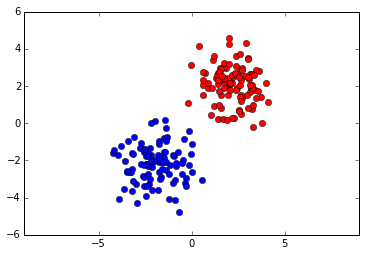

In [63]:
x,y,label,dataName = generateTwoGaussian()
plotData(x,y,label,dataName)


<h2 style="color:red">__Construct Graphs__</h2>

In [64]:
def distance2(p1,p2):
    return (p1[0]-p2[0])**2+(p1[1]-p2[1])**2
def similarity(p1,p2):
    sigma = 10
    return np.exp((-distance2(p1,p2)**2)/(2*(sigma**2)))


def constructMatrix(x,y,label):
    N = x.shape[0]
    # constructing graph
    W = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            W[i,j] = similarity((x[i],y[i]),(x[j],y[j]))

    # construct laplacian
    D = np.diag(np.dot(W,np.ones(N)))
    L = D - W
    return W,D,L

<h2 style="color:red">__unnormalized laplacian method (1)__</h2>

In [65]:
def unnormalized(W,D,L):
    # find eigenvectors and eigenvalues
    eigenValues , eigenVectors = np.linalg.eig(L)
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors

<h2 style="color:red">__normalized laplacian method - Shi & Malik (2)__</h2>

In [66]:
import scipy as sp
def normalized2(W,D,L):
    N = W.shape[0]
    D = np.diag(np.dot(W,np.ones(N)))
    L = D - W
    eigenValues , eigenVectors = sp.linalg.eig(L,D)
    eigenValues = eigenValues.real
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors

<h2 style="color:red">__normalized laplacian method - Ng & Jordan (2)__</h2>

In [67]:
def normalized3(W,D,L):
    N = W.shape[0]
    d = np.diag(D)
    d1 = 1/np.sqrt(d)
    D1 = np.diag(d1)
    Lsym = np.dot(np.dot(D1,L),D1)

    eigenValues , eigenVectors = np.linalg.eig(Lsym)
    eigenValues = eigenValues.real
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors

<h2 style="color:red">__Plot EigenMap__</h2>

In [68]:
def eigPlot(eigenValues,eigenVectors,label,model):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    N = eigenValues.shape[0]
    #1
    eig0 = (eigenVectors[:,0])[label == 0]
    eig1 = (eigenVectors[:,0])[label == 1]
    ax1.plot(range(len(eig0)),eig0,'bx')
    ax1.plot(range(len(eig0),N),eig1,'rx')
    ax1.text(.5,.9,'1st eigenVector',
            horizontalalignment='center',
            transform=ax1.transAxes)
    #2
    eig0 = (eigenVectors[:,1])[label == 0]
    eig1 = (eigenVectors[:,1])[label == 1]
    ax2.plot(range(len(eig0)),eig0,'bx')
    ax2.plot(range(len(eig0),N),eig1,'rx')
    ax2.text(.5,.9,'2nd eigenVector',
            horizontalalignment='center',
            transform=ax2.transAxes)
    #3
    eig0 = (eigenVectors[:,2])[label == 0]
    eig1 = (eigenVectors[:,2])[label == 1]
    ax3.plot(range(len(eig0)),eig0,'bx')
    ax3.plot(range(len(eig0),N),eig1,'rx')
    ax3.text(.5,.9,'3rd eigenVector',
            horizontalalignment='center',
            transform=ax3.transAxes)
    #4
    eig0 = (eigenVectors[:,3])[label == 0]
    eig1 = (eigenVectors[:,3])[label == 1]
    ax4.plot(range(len(eig0)),eig0,'bx')
    ax4.plot(range(len(eig0),N),eig1,'rx')
    ax4.text(.5,.9,'4th eigenVector',
            horizontalalignment='center',
            transform=ax4.transAxes)
    
    plt.savefig('eigenVectos '+model+'.jpg')
    plt.show()
    xt = eigenVectors[:,0]
    yt = eigenVectors[:,1]
    plt.plot(xt[label==0], yt[label==0], 'bo')
    plt.plot(xt[label==1], yt[label==1], 'ro')

    plt.title('new representation '+model)
    plt.savefig('new representation '+model+'.jpg')
    plt.show()

    plt.plot(range(10),eigenValues[:10],'bo')
    plt.title('eigenValues '+model)
    
    plt.savefig('eigenValues '+model+'.jpg')
    plt.show()
    print eigenValues[:10]

<h2 style="color:red">__Visual (1)__</h2>

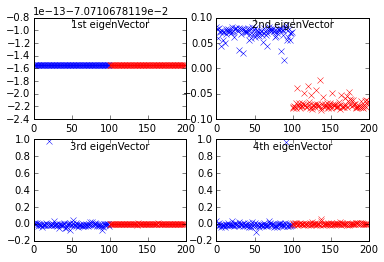

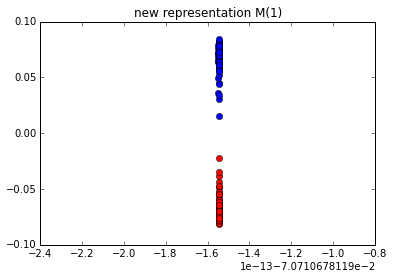

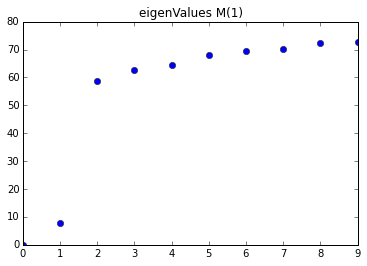

[  3.55271368e-15   7.73405721e+00   5.87442071e+01   6.24972261e+01
   6.45839563e+01   6.79555576e+01   6.93794778e+01   7.03451538e+01
   7.22497999e+01   7.26053080e+01]


In [69]:
W,D,L = constructMatrix(x,y,label)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues,eigenVectors,label,'M(1)')

<h2 style="color:red">__Visual (2)__</h2>

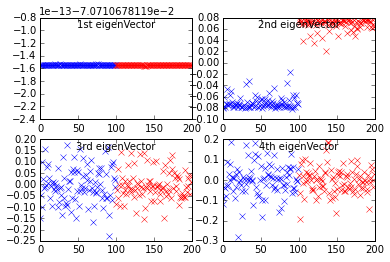

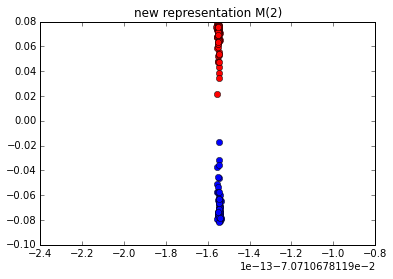

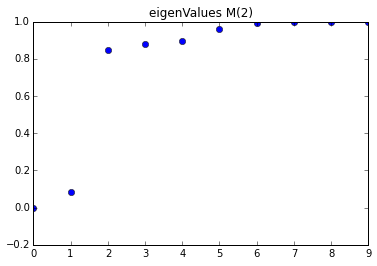

[ -7.34865809e-17   8.38078452e-02   8.45820457e-01   8.78879751e-01
   8.96390059e-01   9.57652952e-01   9.93728663e-01   9.95307544e-01
   9.95368112e-01   9.96802986e-01]


In [70]:
W,D,L = constructMatrix(x,y,label)
eigenValues,eigenVectors = normalized2(W,D,L)
eigPlot(eigenValues,eigenVectors,label,'M(2)')

<h2 style="color:red">__Visual (3)__</h2>

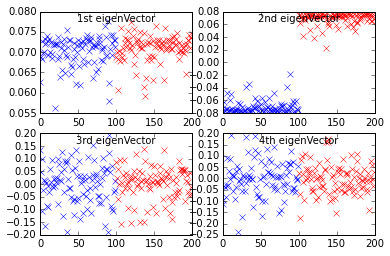

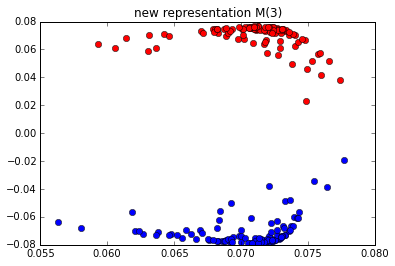

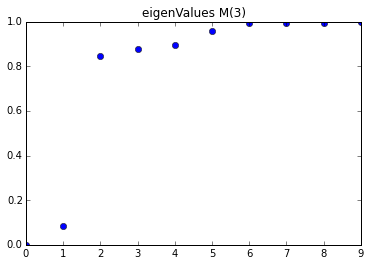

[  9.71445147e-17   8.38078452e-02   8.45820457e-01   8.78879751e-01
   8.96390059e-01   9.57652952e-01   9.93728663e-01   9.95307544e-01
   9.95368112e-01   9.96802986e-01]


In [71]:
W,D,L = constructMatrix(x,y,label)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot(eigenValues,eigenVectors,label,'M(3)')